This notebook is to build a very elementary neural network, trying to predict the expression of certain genes based on DNA sequences in non-coding regions.

In [2]:
import os
from Bio import SeqIO
import numpy as np
import tensorflow as tf
import timeit

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Data Processing
We first perform the **one hot encoding** to translate the DNA based "AGCT" into corresponding 0/1 values. One thing to note is that there does exist 'n's in lots of DNA sequences, and we treat them as all false.

In [3]:
base_pairs = {'A': [1, 0, 0, 0], 
'C': [0, 1, 0, 0],
'G': [0, 0, 1, 0],
'T': [0, 0, 0, 1],
'a': [1, 0, 0, 0],
'c': [0, 1, 0, 0],
'g': [0, 0, 1, 0],
't': [0, 0, 0, 1],
'n': [0, 0, 0, 0],
'N': [0, 0, 0, 0]}

Following are some functions to get the one hot encoded DNA data into some input matrix that can be fed into neural network algorithms. The major things to note are the following:
1. DNA sequences are of difference lengths, some very short (100~ bases), some very long (3000~ bases). Since most sequences are in the length range 1000 - 2000, we decide to only take the first 1000 bases of each sequence to train the neural network and make the predictions. If too long, simply truncate it to length 1000. If too short, simply fill with zeros to extend it. 
2. DNA sequences are in different strands, some in negative strand, some in positive. We take the complement of the sequence if it is taken form the negative strand so thsat all our data is from the same (positive) strand.
3. The entire sequence is *flattend*. For example, AGCT would be transformed into [1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1] where the first four represent A and the next four represent G and so on.

In [4]:
def align_sequence(length, sequence):
    if len(sequence) > length:
        aligned_seq = sequence[:length]
    else:
        aligned_seq = sequence + [0]*(length-len(sequence))
    return aligned_seq

In [5]:
# NOT used
def to_positive_strand(strand, sequence):
    if strand == '-':
        unflattened_seq = [base_pairs[n] for n in sequence.complement()]
    else:
        unflattened_seq = [base_pairs[n] for n in sequence]

In [6]:
def process_seq_record(seq_record, X, y, length_read):
    header = seq_record.description.split('|')
    expressed = int(header[1])
    y.append(expressed)
    # unflattened_seq = to_positive_strand(header[3], seq_record.seq)
    # NO NEED to reverse complement
    unflattened_seq = [base_pairs[n] for n in seq_record.seq]
    flattened_seq = [i for x in unflattened_seq for i in x]
    aligned_seq = align_sequence(length_read, flattened_seq)
    X.append(np.array(aligned_seq))

In [7]:
def read_file(file, X, y, length_read):
    seq_record_list = list(SeqIO.parse("../data/input/3.24_species_only/" + file,"fasta"))
    for i in range(len(seq_record_list)):
        process_seq_record(seq_record_list[i], X, y, length_read)

Training size is the number of files to read for training. Read 200 files would give us 2400 sequences. <br/> For this simple model, we use 4800 sequence to train the neural network and 480 sequences to test its performance.

In [8]:
def prepare_input(training_size, test_size, length_read):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    file_count = 0
    for file in os.listdir("../data/input/3.24_species_only"):
        if file.endswith(".fa"):
            if (file_count < training_size):
                read_file(file, X_train, y_train, length_read)
            elif (file_count < training_size + test_size):
                read_file(file, X_test, y_test, length_read)
            file_count += 1
    return X_train, y_train, X_test, y_test

def to_np_array(X_train, y_train, X_test, y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    if len(y_train.shape) == 1:
        y_train = np.transpose(np.array([y_train]))
    X_test = np.array(X_test)
    y_test = np.transpose(np.array(y_test))
    if len(y_test.shape) == 1:
        y_test = np.transpose(np.array([y_test]))
    return X_train, y_train, X_test, y_test

We examine the shape of all the training and test data matrix to check that the above code works as we expected.

In [9]:
X_train, y_train, X_test, y_test = prepare_input(200, 20, 4000)
X_train, y_train, X_test, y_test = to_np_array(X_train, y_train, X_test, y_test)
[X_train.shape, y_train.shape, X_test.shape, y_test.shape]

[(4800, 4000), (4800, 1), (480, 4000), (480, 1)]

### Logistic Regression
Before actually getting into the neural network, we first try to implement a very simple logistic regression model to get a taste of the prediction procedure.

In [10]:
from sklearn import linear_model as lm

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [11]:
model = lm.LogisticRegression()
model.fit(X_train, y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
y_predicted = np.array(model.predict(X_test))
round(sum(y_test.ravel() == y_predicted)/y_test.shape[0], 3)

0.54

This result of the rate of  correct prediction is slightly better, if any, than random guessing. This suggests that a lot of work needs to be done before we get a satisfying neural network.

### Neural Network with Keras
Now that we have the data ready in the desired numpy array format with correct shapes, we can proceed to train the neural network with our training data in keras and use our test data to see how accurate it performs.

The following cell implements a sequential neural network with 1 input layer (4000 neurons), 4 hidden layers (1000, 400, 40, 10 neurons repectively) and 1 output layer with keras. <br/>
All layers except the final use **relu** or **elu** as activation functions while the final layer uses **sigmoid** as activation function. The cost fucntion is just defined as the binary crossentrophy. <br/> We train our neural network with 12000 DNA sequences in our training data set.

In [13]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential

def train_nn(X_train, y_train, pr):
    model = Sequential()
    model.add(Dense(units=1000, activation='relu', input_dim=4000))
    model.add(Dense(units=400, activation='relu'))
    model.add(Dense(units=40, activation='relu'))
    model.add(Dense(units=10, activation='elu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer = 'SGD',
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
    model.fit(X_train, y_train, batch_size=100, epochs=5, verbose = pr)
    return model

Using TensorFlow backend.


We can see the accuracy on the training set reaches 83% after 10 epoches. <br/>
Now we test the performance of this model with our test data. <br/> The test data contains 1200 DNA sequences. This size, I think, is already big enough for us to believe that the performance on this test data is quite representative of how the model would perform on new data in general (in other words, with little bias). 

In [14]:
def test_accuracy(model, X_test, y_test):
    result = model.predict(X_test)
    correct = list(np.apply_along_axis(lambda x: 0 if x<0.5 else 1, 1, result))==y_test.ravel()
    return round(sum(correct)/y_test.shape[0], 3)

In [15]:
test_accuracy(train_nn(X_train, y_train, 1), X_test, y_test)

Epoch 1/5
4800/4800 [==============================] - 3s 658us/step - loss: 0.6756 - acc: 0.6019
Epoch 2/5
4800/4800 [==============================] - 3s 567us/step - loss: 0.6500 - acc: 0.6254
Epoch 3/5
4800/4800 [==============================] - 3s 578us/step - loss: 0.6231 - acc: 0.6517
Epoch 4/5
4800/4800 [==============================] - 3s 577us/step - loss: 0.5933 - acc: 0.6831
Epoch 5/5
4800/4800 [==============================] - 3s 574us/step - loss: 0.5560 - acc: 0.7281


0.588

The result is roughly 59%, slightly better than random guessing, which at least suggests that the neural network is actually running. <br/>
However, it is still far from what would be considered a satisfying prediction algorithm.

Some major points to consider that may be helpful to improving the performance of the neural network:
1. Use more complex neural network structure rather than the simple sequential model used above.
2. Incorporate other information like what region of genome is the sequence located, the mapping of transcription factors, etc.
3. Improve the way sequences of different lengths are aligned (Our current approach is truncating the long, filling zero with the short, which probably is too naive and causes significant loss of information)

### Time estimate with data size increase

In the previous work, we only used 500 files as training data and 50 files as test data. Also, only 1000 bases are read as all information after that is simply forgone. <br/>
Now we want to see how much time approximately would it take for the program to run if we increase the sample size and the number of files we read in to train the neural network.

We begin by studying the time required for reading in the file and turing the AGCT information into the desired matrices.

In [50]:
file_num = list(range(100, 3000, 100))
read_time_taken = []

for training_size in range(100, 1000, 100):
    test_size = training_size * 0.1
    start_time = timeit.default_timer()
    X_train, y_train, X_test, y_test = prepare_input(training_size, test_size, 4000)
    X_train, y_train, X_test, y_test = to_np_array(X_train, y_train, X_test, y_test)
    elapsed = timeit.default_timer() - start_time
    print("Time to read " + str(int(training_size * 1.1)) + " files is " + str(round(elapsed, 2)) + " seconds")
    time_taken.append(elapsed)

Time to read 110 files is 4.1 seconds
Time to read 220 files is 7.8 seconds
Time to read 330 files is 12.83 seconds
Time to read 440 files is 16.6 seconds
Time to read 550 files is 19.88 seconds
Time to read 660 files is 24.94 seconds
Time to read 770 files is 41.65 seconds
Time to read 880 files is 45.98 seconds
Time to read 990 files is 42.15 seconds


It seems to me that the time increase is linear with the increase of the number of files to read in. Read 3300 files (3000 for training and 300 for test) should take less than 3 minutes.

Then we study the time increase to train the neural network with the more data and also the improvement of accuracy.

In [16]:
file_num = list(range(100, 3000, 100))
total_time_taken = []

for training_size in range(100, 1000, 100):
    test_size = training_size * 0.1
    start_time = timeit.default_timer()
    X_train, y_train, X_test, y_test = prepare_input(training_size, test_size, 4000)
    X_train, y_train, X_test, y_test = to_np_array(X_train, y_train, X_test, y_test)
    result = test_accuracy(train_nn(X_train, y_train, 0), X_test, y_test)
    elapsed = timeit.default_timer() - start_time
    print("Time to read and train with " + str(int(training_size * 1.1)) + " files is " + str(round(elapsed, 2)) + " seconds"
         + ", the result accuracy is " + str(result))
    total_time_taken.append(elapsed)

Time to read and train with 110 files is 11.07 seconds, the result accuracy is 0.483
Time to read and train with 220 files is 24.54 seconds, the result accuracy is 0.59
Time to read and train with 330 files is 33.1 seconds, the result accuracy is 0.668
Time to read and train with 440 files is 42.84 seconds, the result accuracy is 0.491
Time to read and train with 550 files is 54.64 seconds, the result accuracy is 0.625
Time to read and train with 660 files is 66.28 seconds, the result accuracy is 0.515
Time to read and train with 770 files is 78.74 seconds, the result accuracy is 0.565
Time to read and train with 880 files is 87.14 seconds, the result accuracy is 0.556
Time to read and train with 990 files is 105.3 seconds, the result accuracy is 0.5


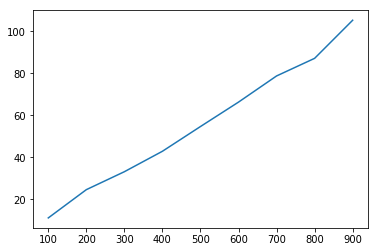

In [22]:
import matplotlib.pyplot as plt
plt.plot(list(range(100, 1000, 100)), total_time_taken)

It appears that the time to read and train the neural network is also linear to the number of files.